In [31]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [32]:
# 讀取資料並指定標籤
labels = ['polarity', 'id', 'date', 'query', 'user', 'text']
data = pd.read_csv("../Data/training.1600000.processed.noemoticon.csv", 
                   names=labels,
                   encoding='latin-1')
data = data.dropna()

In [33]:
# 只保留文字內容和極性，將極性改為 0(負面推文)、1(正面推文)
data = data[['text', 'polarity']]
data.polarity.replace(4, 1, inplace=True)

In [34]:
data.text

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, Length: 1600000, dtype: object

In [35]:
# 創建一個停用詞列表
# from nltk.corpus import stopwords
stops = stopwords.words("english")

# 添加不帶單引號的停用詞 dont(原先為don't) 加入停用詞
no_quotes = []
for word in stops:
    if "'" in word:
        no_quotes.append(re.sub(r'\'', '', word))
stops.extend(no_quotes)

In [36]:
# 刪除推文中的主題標籤(hashtag)、URL、HTML屬性等
def clean_string(string):
    # 刪除 HTML 特殊字元
    tmp = re.sub(r'\&\w*;', '', string)
    # 刪除 @user
    tmp = re.sub(r'@(\w+)', '', tmp)
    # 刪除鏈結
    tmp = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', 
                 '', 
                 tmp)
    # 轉小寫
    tmp = tmp.lower()
    # 刪除主題標籤(hashtag)
    tmp = re.sub(r'#(\w+)', '', tmp)
    # 刪除重複字元
    tmp = re.sub(r'(.)\1{1,}', r'\1\1', tmp)
    # 刪除任何不是字母的東西
    tmp = re.sub("[^a-zA-Z]", " ", tmp)
    # 刪除少於兩個字元的任何內容
    tmp = re.sub(r'\b\w{1,2}\b', '', tmp)
    # 刪除多個空格
    tmp = re.sub(r'\s\s+', ' ', tmp)
    return tmp

In [37]:
# # 詞幹提取(stemming):將單詞還原為字根 EX:love、loving、loved都視為love
# stemmer = PorterStemmer()
# print(stemmer.stem('working'))

In [38]:
# 刪除所有標點符號以及停用詞，並提取每個單字的詞幹
def preprocess(string):
#     from nltk.stem import PorterStemmer
#     from string import punctuation
    stemmer = PorterStemmer() 
    # 刪除標點符號
    removed_punc = ''.join([char for char in string 
                            if char not in punctuation])

    cleaned = []
    # 刪除停用詞
    for word in removed_punc.split(' '):
        if word not in stops:
            cleaned.append(stemmer.stem(word.lower()))  # 詞幹提取(stemming)
    return ' '.join(cleaned)

In [39]:
# 先將文字資料轉換成數值向量，接著呼叫check_classifier來訓練每一個基學習器，並且計算基學習器在驗證資料上的效果，最後匯出結果到指定的檔案。
def check_features_ngrams(features, n_grams, classifiers): # (特徵數量、n-gram的n值 tuple、基學習器)

    print(features, n_grams)
#     from sklearn.feature_extraction.text import TfidfVectorizer
    # 初始化 TfidfVectorizer 函式
    tf = TfidfVectorizer(max_features = features, 
                         ngram_range = n_grams,
                         stop_words = 'english')

    # 將文字資料轉換成數值向量
    tf.fit(data.text)
    transformed = tf.transform(data.text)

    np.random.seed(123456)

    def check_classifier(name, classifier):
        print('--'+name+'--')

        # 將稀疏矩陣轉換成numpy矩陣
        x_data = transformed[:train_size].toarray() # 將資料轉換成模型可以接收的numpy矩陣資料型別
        y_data = data.polarity[:train_size].values

        # 訓練基學習器
        classifier.fit(x_data, y_data)
        i_s = metrics.accuracy_score(y_data, 
                                     classifier.predict(x_data))

        # 在測試集上評估基學習器效能
        x_data = transformed[test_start:test_end].toarray()
        y_data = data.polarity[test_start:test_end].values
        oos = metrics.accuracy_score(y_data, 
                                     classifier.predict(x_data))

        # 匯出結果
        with open("outs.txt","a") as f:
            f.write(str(features)+',')
            f.write(str(n_grams[-1])+',')
            f.write(name+',')
            f.write('%.4f'%i_s+',')
            f.write('%.4f'%oos+'\n')

    for name, classifier in classifiers:
        check_classifier(name, classifier)


In [40]:
# 測試所有特徵和 n-連字串組合
for features in [500, 1000, 5000, 10000, 20000, 30000]:
    for n_grams in [(1, 1), (1, 2), (1, 3)]:
        classifiers=['DT','NB','Ridge','Voting']
#         # 訓練模型
        print(features, n_grams, classifiers)

500 (1, 1) ['DT', 'NB', 'Ridge', 'Voting']
500 (1, 2) ['DT', 'NB', 'Ridge', 'Voting']
500 (1, 3) ['DT', 'NB', 'Ridge', 'Voting']
1000 (1, 1) ['DT', 'NB', 'Ridge', 'Voting']
1000 (1, 2) ['DT', 'NB', 'Ridge', 'Voting']
1000 (1, 3) ['DT', 'NB', 'Ridge', 'Voting']
5000 (1, 1) ['DT', 'NB', 'Ridge', 'Voting']
5000 (1, 2) ['DT', 'NB', 'Ridge', 'Voting']
5000 (1, 3) ['DT', 'NB', 'Ridge', 'Voting']
10000 (1, 1) ['DT', 'NB', 'Ridge', 'Voting']
10000 (1, 2) ['DT', 'NB', 'Ridge', 'Voting']
10000 (1, 3) ['DT', 'NB', 'Ridge', 'Voting']
20000 (1, 1) ['DT', 'NB', 'Ridge', 'Voting']
20000 (1, 2) ['DT', 'NB', 'Ridge', 'Voting']
20000 (1, 3) ['DT', 'NB', 'Ridge', 'Voting']
30000 (1, 1) ['DT', 'NB', 'Ridge', 'Voting']
30000 (1, 2) ['DT', 'NB', 'Ridge', 'Voting']
30000 (1, 3) ['DT', 'NB', 'Ridge', 'Voting']


In [41]:
data = data.sample(frac=1).reset_index(drop=True)  # frac (float)：要抽出的比例，0~1  https://ithelp.ithome.com.tw/articles/10233644
data.text = data.text.apply(clean_string)
data.text = data.text.apply(preprocess)

train_size = 10000
test_start = 10000
test_end = 100000

# 創建 csv 標頭
with open("outs.txt","a") as f:
    f.write('features,ngram_range,classifier,')
    f.write('train_acc,test_acc\n')

# 測試所有特徵和 n-連字串組合
for features in [500, 1000, 5000, 10000, 20000, 30000]:
    for n_grams in [(1, 1), (1, 2), (1, 3)]:

        # 初始化集成模型
        voting = VotingClassifier([('DT', 
                                    DecisionTreeClassifier()),
                                   ('NB',
                                    MultinomialNB()),
                                   ('Ridge', 
                                    RidgeClassifier())])

        # 整合集成模型與單一基學習器
        classifiers = [('DT', 
                        DecisionTreeClassifier()),
                       ('NB', 
                        MultinomialNB()),
                       ('Ridge', 
                        RidgeClassifier()),
                       ('Voting', 
                        voting)]

        # 訓練模型
        check_features_ngrams(features, n_grams, classifiers)

500 (1, 1)
--DT--
--NB--
--Ridge--
--Voting--
500 (1, 2)
--DT--
--NB--
--Ridge--
--Voting--
500 (1, 3)
--DT--
--NB--
--Ridge--
--Voting--
1000 (1, 1)
--DT--
--NB--
--Ridge--
--Voting--
1000 (1, 2)
--DT--
--NB--
--Ridge--
--Voting--
1000 (1, 3)
--DT--
--NB--
--Ridge--
--Voting--
5000 (1, 1)
--DT--
--NB--
--Ridge--
--Voting--
5000 (1, 2)
--DT--
--NB--
--Ridge--
--Voting--
5000 (1, 3)
--DT--
--NB--
--Ridge--
--Voting--
10000 (1, 1)
--DT--
--NB--
--Ridge--
--Voting--
10000 (1, 2)
--DT--
--NB--
--Ridge--
--Voting--
10000 (1, 3)
--DT--
--NB--
--Ridge--
--Voting--
20000 (1, 1)
--DT--
--NB--
--Ridge--
--Voting--
20000 (1, 2)
--DT--
--NB--
--Ridge--
--Voting--
20000 (1, 3)
--DT--
--NB--
--Ridge--
--Voting--
30000 (1, 1)
--DT--
--NB--
--Ridge--
--Voting--
30000 (1, 2)
--DT--
--NB--
--Ridge--
--Voting--
30000 (1, 3)
--DT--
--NB--
--Ridge--
--Voting--


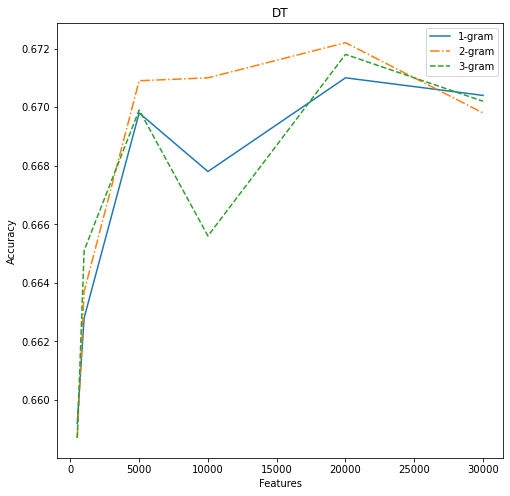

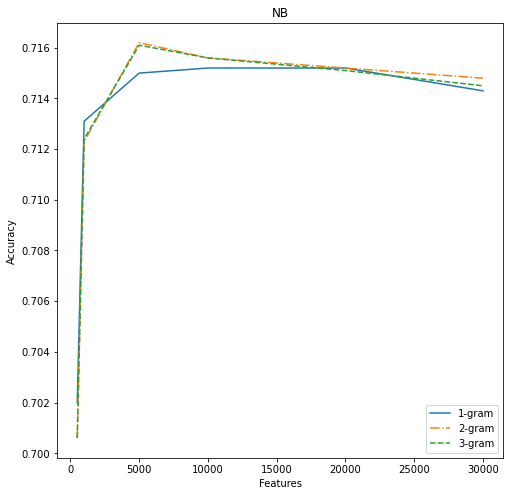

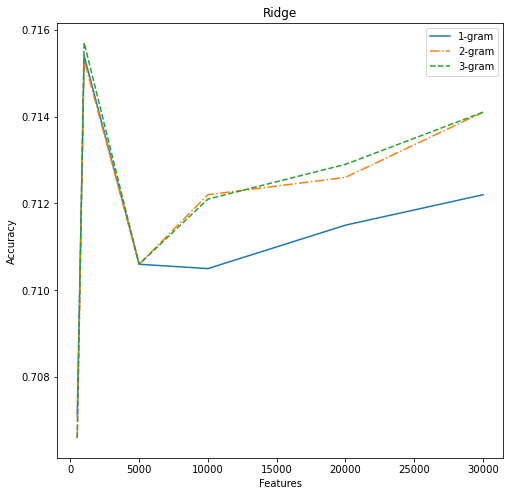

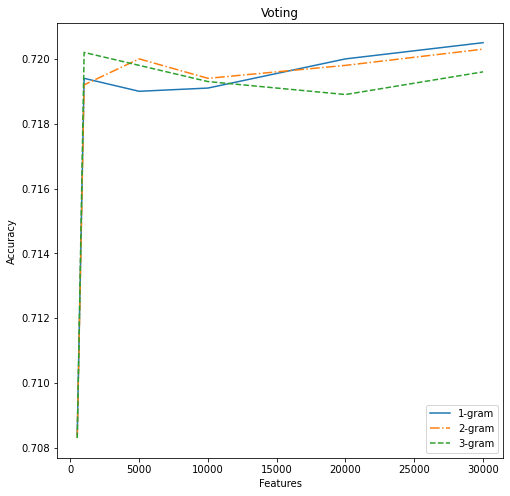

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

text = []
with open("outs.txt", 'r') as f:
   text = f.readlines()
   f.close()

x = [500, 1000, 5000, 10000, 20000, 30000]

for model in ["DT", "NB", "Ridge", "Voting"]:
    gram_1 = []
    gram_2 = []
    gram_3 = []
    for line in text:
        token = line.split(",")
        if(token[2] == model):
            if(int(token[1]) == 1):
                gram_1.append(float(token[4]))
            if(int(token[1]) == 2):
                gram_2.append(float(token[4]))
            if(int(token[1]) == 3):
                gram_3.append(float(token[4]))
    
    plt.figure(figsize = (8, 8))
    plt.plot(x, gram_1, label = "1-gram")
    plt.plot(x, gram_2, label = "2-gram",
             linestyle = "-.")
    plt.plot(x, gram_3, label = "3-gram",
             linestyle = "--")
    plt.xlabel("Features")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(model)
    plt.show()
    plt.close()
